# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [35]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [814]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler, WeightedRandomSampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [815]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([ #Compose позволяет применить несколько трансформаций к датасету, грубо говоря, это - контейнер для трансформаций
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47], # mean и std по 3 штуки, т.к. 3 цветовых канала
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [823]:
batch_size = 64

data_size = data_train.data.shape[0] #число строк в train датасете
validation_split = .2 #процент данных для валидации
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size)) # list с индексами объектов
np.random.shuffle(indices) # рандомно перемешиваем индексы

train_indices, val_indices = indices[split:], indices[:split] #Разделение индексов на train и val выборки

train_sampler = SubsetRandomSampler(train_indices) #объект, необходимый для рандомного разделения указанных индексов из датасета в батчи, в каждой эпохе состав батчей меняется
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, #итератор,возвращающий батч, из рандомно перемешанных с каждой эпохой данных. Аутпут - тензор фичей (x) в 0 элементе и тензор лейблов (y) в первом
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [818]:
counts = np.unique([y for _,y in data_train], return_counts=True)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [819]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [820]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [821]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad() # Обнуление градиентов с прошлого шага. !!!обязательная часть на каждом степе.
            loss_value.backward()
            optimizer.step()
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    success_count = 0
    samples_number = loader.batch_size * len(loader)
    for x, y in loader:
        success_count += torch.sum(torch.argmax(model(x), axis = 1) == y).item()
    
    return success_count / samples_number

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.980371, Train accuracy: 0.334693, Val accuracy: 0.462704
Average loss: 1.607985, Train accuracy: 0.522421, Val accuracy: 0.554144
Average loss: 1.466596, Train accuracy: 0.582432, Val accuracy: 0.581929


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [824]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.262872, Train accuracy: 0.170733, Val accuracy: 0.189888
Average loss: 2.230733, Train accuracy: 0.192967, Val accuracy: 0.190570
Average loss: 2.212282, Train accuracy: 0.192915, Val accuracy: 0.189547
Average loss: 2.193941, Train accuracy: 0.193547, Val accuracy: 0.189820
Average loss: 2.173655, Train accuracy: 0.194980, Val accuracy: 0.192686


Добавьте слой с Batch Normalization

In [825]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    #nn.BatchNorm1d(10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.061076, Train accuracy: 0.333055, Val accuracy: 0.482123
Average loss: 1.729706, Train accuracy: 0.515289, Val accuracy: 0.559566
Average loss: 1.592221, Train accuracy: 0.567689, Val accuracy: 0.597844
Average loss: 1.504875, Train accuracy: 0.598710, Val accuracy: 0.622271
Average loss: 1.443480, Train accuracy: 0.621302, Val accuracy: 0.603029


Добавьте уменьшение скорости обучения по ходу тренировки.

In [836]:
def train_model_fading_lr(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad() # Обнуление градиентов с прошлого шага. !!!обязательная часть на каждом степе.
            loss_value.backward()
            optimizer.step()
            
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        scheduler.step()
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [837]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
         )


optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=.5)
loss_history, train_history, val_history = train_model_fading_lr(nn_model, train_loader, val_loader, loss, optimizer, lr_scheduler, 5)

Average loss: 2.075733, Train accuracy: 0.299253, Val accuracy: 0.417713
Average loss: 1.788422, Train accuracy: 0.460721, Val accuracy: 0.515216
Average loss: 1.665615, Train accuracy: 0.526516, Val accuracy: 0.557997
Average loss: 1.606395, Train accuracy: 0.555199, Val accuracy: 0.583038
Average loss: 1.565217, Train accuracy: 0.575897, Val accuracy: 0.602279


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [838]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    predictions = np.array([], dtype=int)
    ground_truth = np.array([], dtype=int)

    loader = torch.utils.data.DataLoader(dataset,  sampler=sampler)
    for x, y in loader:
        predictions = np.append(predictions, torch.argmax(model(x), axis = 1).numpy())
        ground_truth = np.append(ground_truth, y.numpy())
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

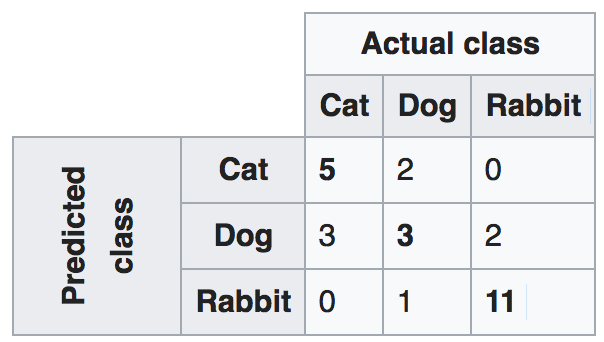

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

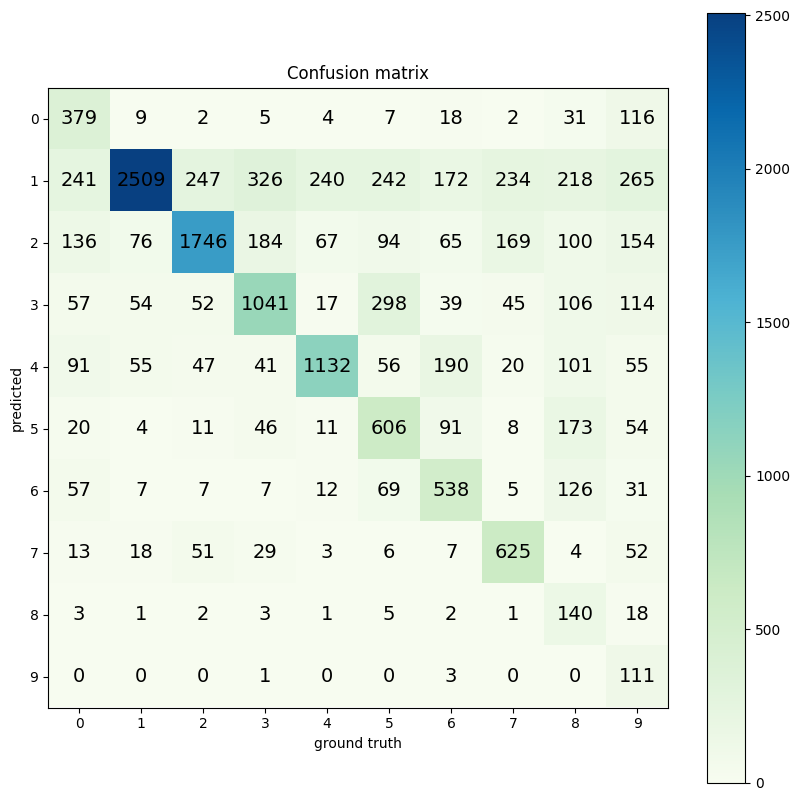

In [841]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), int)
    
    # TODO: Implement filling the prediction matrix
    for i,j in np.array([predictions, gt]).T:
        confusion_matrix[i,j] +=1
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

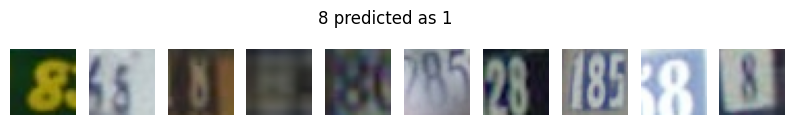

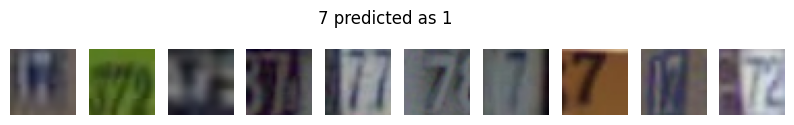

In [842]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    ind_to_show = np.array(val_indices)[(predictions == predicted_class) & (ground_truth == gt_class)]
    visualize_images(ind_to_show, data, title=f'{gt_class} predicted as {predicted_class}')

visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [843]:
my_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 300),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(inplace=True),
    nn.Linear(200, 10),
         )

my_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
#optimizer_sgd = optim.SGD(my_model.parameters(), lr=1e-3, weight_decay=1e-1)
optimizer_adam = optim.Adam(my_model.parameters(), lr = 1e-3)

In [849]:
loss_history, train_history, val_history = train_model(my_model, train_loader, val_loader, loss, optimizer_adam, 5)

Average loss: 0.443684, Train accuracy: 0.859724, Val accuracy: 0.830991
Average loss: 0.443449, Train accuracy: 0.861482, Val accuracy: 0.831332
Average loss: 0.444228, Train accuracy: 0.860885, Val accuracy: 0.830991
Average loss: 0.440607, Train accuracy: 0.862471, Val accuracy: 0.832287
Average loss: 0.440748, Train accuracy: 0.863035, Val accuracy: 0.830991


In [850]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(my_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8120


In [851]:
my_model_2l = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 300),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(300),
    nn.ReLU(inplace=True),
    nn.Linear(300, 10),
         )

my_model_2l.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer_adam = optim.Adam(my_model_2l.parameters(), lr = 1e-3)

In [853]:
loss_history_2l, train_history_2l, val_history_2l = train_model(my_model_2l, train_loader, val_loader, loss, optimizer_adam, 10)

Average loss: 1.076555, Train accuracy: 0.673941, Val accuracy: 0.730759
Average loss: 0.869266, Train accuracy: 0.739634, Val accuracy: 0.740789
Average loss: 0.770316, Train accuracy: 0.768027, Val accuracy: 0.797489
Average loss: 0.712376, Train accuracy: 0.787360, Val accuracy: 0.794555
Average loss: 0.675598, Train accuracy: 0.798314, Val accuracy: 0.803630
Average loss: 0.643731, Train accuracy: 0.806709, Val accuracy: 0.812773
Average loss: 0.617479, Train accuracy: 0.816435, Val accuracy: 0.821575
Average loss: 0.593655, Train accuracy: 0.822800, Val accuracy: 0.806086
Average loss: 0.571587, Train accuracy: 0.827629, Val accuracy: 0.828057
Average loss: 0.562007, Train accuracy: 0.831400, Val accuracy: 0.827170


In [855]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(my_model_w, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8370
